In [1]:
import numpy as np
import sys
import gsw
import xarray as xr
import numpy as np
from scipy import integrate
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
from xgcm import Grid 
import warnings
warnings.filterwarnings('ignore')

from jmd95 import densjmd95

In [2]:
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco

In [3]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

In [5]:
## Load 2D Monthly data...SSH 
data_dir= ECCO_dir + '/nctiles_monthly'
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, \
                                           vars_to_load=['THETA','SALT'],\
                                           years_to_load=range(2007,2008)).load() # if desired, add after 'SSH','NEW_VAR',... 'SSH','OBP',                                           

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  SALT
loading files of  THETA


In [5]:
tile_num = 10
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_theta_2017.nc')
ds = xr.Dataset(
    data_vars=dict(
        theta=(["time","layer","j", "i"], ecco_monthly_ds.THETA.isel(tile=tile_num).data),
    ),
    coords=dict(
        i=(["i"], ecco_monthly_ds.THETA.i.data), 
        j=(["j"], ecco_monthly_ds.THETA.j.data),
        XC=(["j","i"], ecco_monthly_ds.THETA.XC.isel(tile=tile_num).data), 
        YC=(["j","i"], ecco_monthly_ds.THETA.YC.isel(tile=tile_num).data),
        # tile=(["tile"], ecco_monthly_ds.SALT.tile.data), 
        time=(["time"], ecco_monthly_ds.THETA.time.data), 
        layer=(["layer"], np.arange(np.shape(ecco_grid.drF)[0])),
        drF=(["layer"], ecco_grid.drF.data),
        hFacC=(["layer","j","i"], ecco_grid.hFacC.isel(tile=tile_num).data),
    ),
)
ds.to_netcdf(path=filename)

In [5]:
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)

In [6]:
np.shape(ecco_monthly_ds.SALT) # [month, depth, tile, lat,lon]

(12, 50, 13, 270, 270)

In [7]:
H = ecco_monthly_ds.Depth 
# z_star = ((ecco_monthly_ds.Z - ecco_monthly_ds.SSHDYN)/(H + ecco_monthly_ds.SSHDYN))*H

In [8]:
layer_thickness = ecco_grid.hFacC*ecco_grid.drF
zz = layer_thickness.Z
zz = zz.where(layer_thickness != 0, np.nan)

4562.75


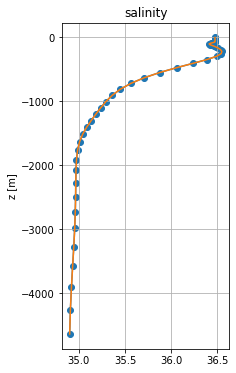

In [9]:
testloc = np.where((ecco_monthly_ds.YC > 33) & (ecco_monthly_ds.YC < 35) & (ecco_monthly_ds.XC > -45) & (ecco_monthly_ds.XC < -43))
test_salt = ecco_monthly_ds.SALT[0,:,testloc[0][0],testloc[1][0],testloc[2][0]]
test_salt = test_salt.where(test_salt>0, np.nan)

f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(test_salt, zz[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.scatter(test_salt, zz[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.plot(test_salt, ecco_monthly_ds.Z)
ax.grid()
ax.set_title('salinity')
ax.set_ylabel('z [m]')

# print(z_star[-1,0,testloc[0][0],testloc[1][0],testloc[2][0]].data)
print(H[testloc[0][0],testloc[1][0],testloc[2][0]].data)
# print(z_star[np.where(np.isnan(test_salt))[0][0]-1,0,testloc[0][0],testloc[1][0],testloc[2][0]].data)

[22.52441   22.515177  22.506668  22.497799  22.488249  22.478876
 22.468882  22.45653   22.43936   22.35635   21.952654  21.295176
 20.686085  20.148727  19.622526  19.01152   18.197206  17.061247
 15.566654  13.83981   12.0985985 10.506389   9.132718   7.971295
  6.9874887  6.1741548  5.5482645  5.1055126  4.8048515  4.595403
  4.4357734  4.3056583  4.201159   4.122177   4.0706244  4.0412793
  4.0249877  4.013759   4.0026197  3.9925888  3.9856756  3.9856708
  0.         0.         0.         0.         0.         0.
  0.         0.       ]


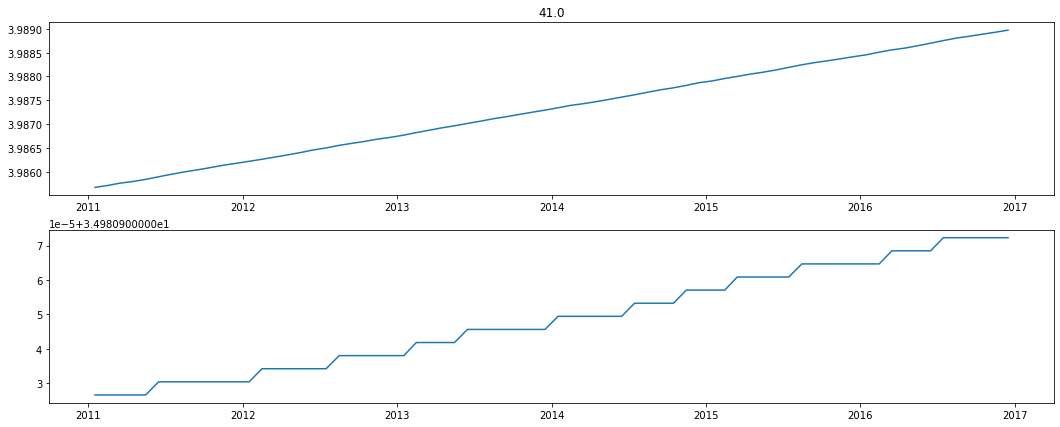

In [99]:
# T/S bottom variability check 
tile_num = 10
lon_test = 36
lat_test = 73 # 70, 73
lons_check = ecco_monthly_ds.XC.sel(tile=tile_num)
lats_check = ecco_monthly_ds.YC.sel(tile=tile_num)
test = np.floor(ecco_grid.hFacC.sum(dim='k')).isel(tile=tile_num) - 0
T_bot = ecco_monthly_ds.THETA.isel(tile=tile_num)
S_bot = ecco_monthly_ds.SALT.isel(tile=tile_num)
print(T_bot[0, :, lon_test, lat_test].data)

f, (ax,ax2) = plt.subplots(2,1,figsize=(18,7))
ax.plot(ecco_monthly_ds.time,(T_bot.isel(k=test.astype(int)))[:, lon_test, lat_test], label=r'bottom density', linewidth=1.5)
ax.set_title(str(test[lon_test, lat_test].data))
ax2.plot(ecco_monthly_ds.time,(S_bot.isel(k=test.astype(int)))[:, lon_test, lat_test], label=r'bottom density', linewidth=1.5)

In [6]:
# density using ECCO equation of state(?) 
tile_num = 10
p = gsw.p_from_z(ecco_monthly_ds.Z, ecco_monthly_ds.YC.isel(tile=tile_num)) # .isel(tile=tile_num)
z = gsw.z_from_p(p, ecco_monthly_ds.YC.isel(tile=tile_num))
# chunk it up so the old function isn't overwhelmed (for 270, only reading in 1 year at a time anyway)
salt = ecco_monthly_ds.SALT.isel(tile=tile_num) # SALT[0:24]
salt = salt.where(salt>0, np.nan)
rho_jmd95 = densjmd95(salt,ecco_monthly_ds.THETA.isel(tile=tile_num),p) # THETA[0:24], .isel(tile=tile_num)

In [13]:
# only needed if chunked above 
salt = ecco_monthly_ds.SALT[24:48]
salt = salt.where(salt>0, np.nan)
rho_jmd95_2 = densjmd95(salt,ecco_monthly_ds.THETA[24:48],p)

In [14]:
# only needed if chunked above 
salt = ecco_monthly_ds.SALT[48:]
salt = salt.where(salt>0, np.nan)
rho_jmd95_3 = densjmd95(salt,ecco_monthly_ds.THETA[48:],p)

In [15]:
# only need if broken up into three chunks for size's sake 
rho_jmd95 = np.concatenate((rho_jmd95,rho_jmd95_2,rho_jmd95_3),axis=0)

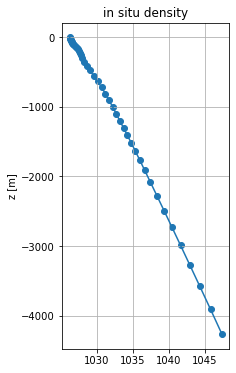

In [16]:
testloc = np.where((ecco_monthly_ds.YC > 33) & (ecco_monthly_ds.YC < 35) & (ecco_monthly_ds.XC > -45) & (ecco_monthly_ds.XC < -43))
f, ax = plt.subplots(1,1,figsize=(3,6))
ax.plot(rho_jmd95[0,:,testloc[0][0],testloc[1][0],testloc[2][0]], z[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.scatter(rho_jmd95[0,:,testloc[0][0],testloc[1][0],testloc[2][0]], z[:,testloc[0][0],testloc[1][0],testloc[2][0]])
ax.set_title('in situ density')
ax.set_ylabel('z [m]')
ax.grid()

## Procedure
- calculaute in-situ density at each grid point for each month of time series 
- steric height = (1/ $\rho_0$ ) vertical sum of density anomalies * cell thickness ... (using drF and hFacC)

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


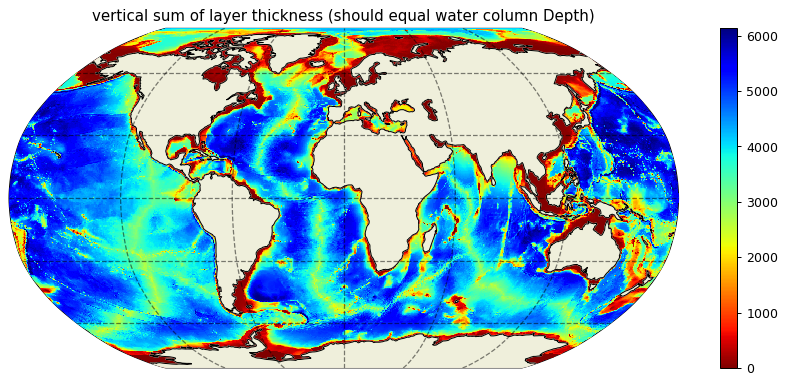

In [11]:
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, np.sum(ecco_grid.hFacC*ecco_grid.drF, axis=0), \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True,dx=0.5,dy=0.5,cmap='jet_r');
plt.title('vertical sum of layer thickness (should equal water column Depth)');

In [7]:
# FOR LLC 270 only 1 tile 
rho0 = 1035; g = 9.81;
rho_pr_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3]))
rho_int_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd[i] = np.sum((rho_jmd95[i]-rho0)*ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF, axis=0) # .isel(tile=tile_num)
    rho_int_jmd[i] = np.sum((rho_jmd95[i])*ecco_grid.hFacC.isel(tile=tile_num)*ecco_grid.drF, axis=0) # .isel(tile=tile_num)
steric_height_jmd = (-1/rho0)*rho_pr_jmd
steric_height_p_jmd = (-1*g)*rho_int_jmd

In [8]:
# FOR LLC 270 only 1 tile .isel(tile=tile_num)
density_jmd_xr = xr.DataArray(
    data=rho_jmd95,
    dims=["time","layer","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["j","i"], ecco_monthly_ds.SALT.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.SALT.YC.isel(tile=tile_num).data), 
        time=(["time"], ecco_monthly_ds.SALT.time.data), layer=(["layer"], np.arange(np.shape(ecco_grid.drF)[0])), # tile=(["tile"], ecco_monthly_ds.SALT.tile.data)
    ),
)
steric_height_jmd_xr = xr.DataArray(
    data=steric_height_jmd,
    dims=["time","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["j","i"], ecco_monthly_ds.SALT.XC.isel(tile=tile_num).data), YC=(["j","i"], ecco_monthly_ds.SALT.YC.isel(tile=tile_num).data),
        time=(["time"], ecco_monthly_ds.SALT.time.data), # tile=(["tile"], ecco_monthly_ds.SALT.tile.data), 
    ),
)
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/rho_270_steric_2007.nc')
ds = xr.Dataset(
    data_vars=dict(
        rho=(["time","layer","j", "i"], rho_jmd95),
        steric=(["time","j", "i"], steric_height_jmd),
        steric_p=(["time","j", "i"], steric_height_p_jmd),
    ),
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), 
        j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["j","i"], ecco_monthly_ds.SALT.XC.isel(tile=tile_num).data), 
        YC=(["j","i"], ecco_monthly_ds.SALT.YC.isel(tile=tile_num).data),
        # tile=(["tile"], ecco_monthly_ds.SALT.tile.data), 
        time=(["time"], ecco_monthly_ds.SALT.time.data), 
        layer=(["layer"], np.arange(np.shape(ecco_grid.drF)[0])),
        drF=(["layer"], ecco_grid.drF.data),
        hFacC=(["layer","j","i"], ecco_grid.hFacC.isel(tile=tile_num).data),
    ),
)
ds.to_netcdf(path=filename)

In [50]:
rho0 = 1035
g = 9.81
# rho_pr_jmd_old = integrate.cumulative_trapezoid(rho_jmd95-rho0,x=np.tile(z, (np.shape(salt)[0],1,1,1,1)),axis=1)
rho_pr_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
rho_int_jmd = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd[i] = np.sum((rho_jmd95[i]-rho0)*ecco_grid.hFacC*ecco_grid.drF, axis=0)
    rho_int_jmd[i] = np.sum((rho_jmd95[i])*ecco_grid.hFacC*ecco_grid.drF, axis=0)
steric_height_jmd = (-1/rho0)*rho_pr_jmd
steric_height_p_jmd = (-1*g)*rho_int_jmd

In [25]:
density_jmd_xr = xr.DataArray(
    data=rho_jmd95,
    dims=["time","layer","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data), 
        layer=(["layer"], np.arange(np.shape(ecco_grid.drF)[0]))
    ),
)
steric_height_jmd_xr = xr.DataArray(
    data=steric_height_jmd,
    dims=["time","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data),
    ),
)

In [52]:
# save file 
# -------------------------------
filename = ('/Users/jakesteinberg/Documents/NASA_OSTST/rho_steric_2011_2017.nc')
ds = xr.Dataset(
    data_vars=dict(
        rho=(["time","layer","tile","j", "i"], rho_jmd95),
        steric=(["time","tile","j", "i"], steric_height_jmd),
        steric_p=(["time","tile","j", "i"], steric_height_p_jmd),
    ),
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), 
        j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), 
        YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), 
        time=(["time"], ecco_monthly_ds.SALT.time.data), 
        layer=(["layer"], np.arange(np.shape(ecco_grid.drF)[0])),
        drF=(["layer"], ecco_grid.drF.data),
        hFacC=(["layer","tile","j","i"], ecco_grid.hFacC.data),
    ),
)
ds.to_netcdf(path=filename)

In [37]:
# upper 1000m
rho_pr_jmd_1000 = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd_1000[i] = np.sum((rho_jmd95[i][0:29]-rho0)*ecco_grid.hFacC[0:29]*ecco_grid.drF[0:29], axis=0)
steric_height_jmd_1000 = (-1/rho0)*rho_pr_jmd_1000
# deeper 
rho_pr_jmd_deep = np.nan*np.ones((np.shape(rho_jmd95)[0],np.shape(rho_jmd95)[2],np.shape(rho_jmd95)[3],np.shape(rho_jmd95)[4]))
for i in range(np.shape(rho_jmd95)[0]):
    rho_pr_jmd_deep[i] = np.sum((rho_jmd95[i][29:]-rho0)*ecco_grid.hFacC[29:]*ecco_grid.drF[29:], axis=0)
steric_height_jmd_deep = (-1/rho0)*rho_pr_jmd_deep

steric_height_jmd_1000_xr = xr.DataArray(
    data=steric_height_jmd_1000,
    dims=["time","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data),
    ),
)
steric_height_jmd_deep_xr = xr.DataArray(
    data=steric_height_jmd_deep,
    dims=["time","tile","j", "i"],
    coords=dict(
        i=(["i"], ecco_monthly_ds.SALT.i.data), j=(["j"], ecco_monthly_ds.SALT.j.data),
        XC=(["tile","j","i"], ecco_monthly_ds.SALT.XC.data), YC=(["tile","j","i"], ecco_monthly_ds.SALT.YC.data),
        tile=(["tile"], ecco_monthly_ds.SALT.tile.data), time=(["time"], ecco_monthly_ds.SALT.time.data),
    ),
)

In [78]:
np.shape(SSHDYN_global_mean_mon)

(72,)

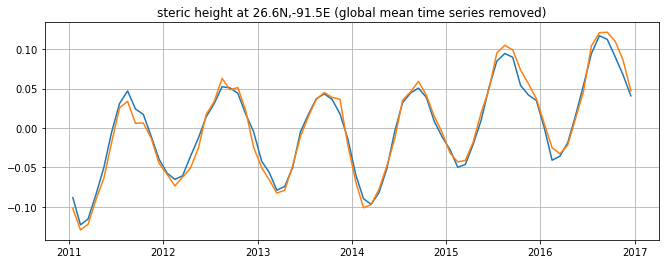

In [80]:
test_lon = -91.5
test_lat = 26.578028
testloc = np.where((ecco_monthly_ds.YC.isel(tile=10) > (test_lat-0.75)) & (ecco_monthly_ds.YC.isel(tile=10) < (test_lat+0.75)) & \
                   (ecco_monthly_ds.XC.isel(tile=10) > (test_lon-0.75)) & (ecco_monthly_ds.XC.isel(tile=10) < (test_lon+0.75)))
months = ecco_monthly_ds.time
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)
steric_height_global_mean = (steric_height_jmd_xr*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height_r = steric_height_jmd_xr - steric_height_jmd_xr.mean(dim='time') # - steric_height_global_mean

SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSHDYN_minus_global_mean = ecco_monthly_ds.SSHDYN - ecco_monthly_ds.SSHDYN.mean(dim='time') # SSHDYN_global_mean_mon

f, ax = plt.subplots(1,1,figsize=(11,4))
ax.plot(months, steric_height_r[:,10,testloc[0][0],testloc[1][0]])
ax.plot(months, SSHDYN_minus_global_mean[:,10,testloc[0][0],testloc[1][0]])
ax.set_title('steric height at ' + str(np.round(ecco_monthly_ds.YC.isel(tile=10)[testloc[0][0],testloc[1][0]].data,1)) + 'N,' + \
             str(np.round(ecco_monthly_ds.XC.isel(tile=10)[testloc[0][0],testloc[1][0]].data,1)) + 'E (global mean time series removed)') 
ax.grid()

In [38]:
# STERIC HEIGHT TREND
days_since_first_record = ((ecco_monthly_ds.time - ecco_monthly_ds.time[0])/(86400e9)).astype(int).values

sh_flat = np.reshape(steric_height_r.values, (len(steric_height_r.time), 13*90*90))
sh_flat[np.nonzero(np.isnan(sh_flat))] = 0
# slope is in m / day
sh_slope, sh_intercept = np.polyfit(days_since_first_record, sh_flat, 1)
# and reshape the slope result back to 13x90x90    
sh_slope_all = np.reshape(sh_slope, (13,90,90))

# upper 1000
steric_height_1000_global_mean = (steric_height_jmd_1000_xr*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height_r_1000 = steric_height_jmd_1000_xr - steric_height_1000_global_mean
sh_flat = np.reshape(steric_height_r_1000.values, (len(steric_height_r.time), 13*90*90))
sh_flat[np.nonzero(np.isnan(sh_flat))] = 0
sh_slope, sh_intercept = np.polyfit(days_since_first_record, sh_flat, 1)  
sh_slope_1000 = np.reshape(sh_slope, (13,90,90))
# deep
steric_height_deep_global_mean = (steric_height_jmd_deep_xr*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
steric_height_r_deep = steric_height_jmd_deep_xr - steric_height_deep_global_mean
sh_flat = np.reshape(steric_height_r_deep.values, (len(steric_height_r.time), 13*90*90))
sh_flat[np.nonzero(np.isnan(sh_flat))] = 0
sh_slope, sh_intercept = np.polyfit(days_since_first_record, sh_flat, 1)  
sh_slope_deep = np.reshape(sh_slope, (13,90,90))

sh_trend = xr.DataArray(
    data=sh_slope_all,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], steric_height_r.XC.data), YC=(["tile","j","i"], steric_height_r.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
sh_1000_trend = xr.DataArray(
    data=sh_slope_1000,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], steric_height_r.XC.data), YC=(["tile","j","i"], steric_height_r.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)
sh_deep_trend = xr.DataArray(
    data=sh_slope_deep,
    dims=["tile","j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
        XC=(["tile","j","i"], steric_height_r.XC.data), YC=(["tile","j","i"], steric_height_r.YC.data),
        tile=(["tile"], np.arange(13)),
    ),
)

In [21]:
# rho_pr_ind = np.nan*np.ones(np.shape(rho_jmd95[:,0]))
# for m in range(np.shape(rho_jmd95)[0]):
#     print(m)
#     for k in range(np.shape(rho_jmd95)[2]):
#         for j in range(np.shape(rho_jmd95)[3]):
#             for i in range(np.shape(rho_jmd95)[4]):
#                 if ~np.isnan(ocean_mask[0,k,j,i]):
#                     this_rho_pr = rho_jmd95[m,:,k,j,i]-rho0
#                     good = np.where(~np.isnan(this_rho_pr))[0]
#                     rho_pr_ind[m,k,j,i] = integrate.cumulative_trapezoid(this_rho_pr[good], x=z[good,k,j,i].data)[-1]

In [11]:
# p_test = gsw.p_from_z(ecco_monthly_ds.Z, ecco_monthly_ds.YC)
# z_test = gsw.z_from_p(p_test, ecco_monthly_ds.YC)
# z_test = z_test.transpose('time','k','tile','j','i')
# this_salt_test = ecco_monthly_ds.SALT
# this_salt_test = this_salt_test.where(this_salt_test>0, np.nan)
# this_sa_test = gsw.SA_from_SP(this_salt_test, p_test, ecco_monthly_ds.XC, ecco_monthly_ds.YC)
# this_ct_test = gsw.CT_from_pt(this_sa_test, ecco_monthly_ds.THETA)
# rho_test = gsw.rho(this_sa_test, this_ct_test, p_test)
# rho0 = 1035
# rho_prime_int = integrate.cumtrapz(rho_test-rho0,z_test,axis=1)
# steric_height = (-1/rho0)*((np.tile(H, (np.shape(z_test)[0],1,1,1))+\
#                             ecco_monthly_ds.SSH)/np.tile(H, (np.shape(z_test)[0],1,1,1)))*rho_prime_int[:,0]

-179.5 179.5
-180.0 180.0
-89.5 89.5
-90.0 90.0


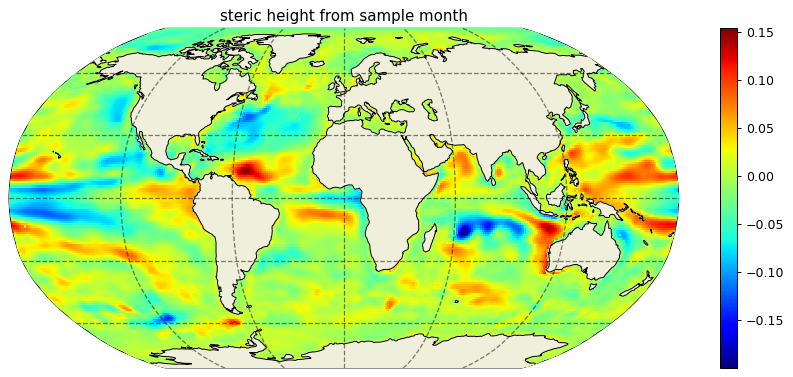

In [39]:
# steric height from one month - local time mean
to_plot = steric_height_jmd_xr[5] - steric_height_jmd_xr.mean(dim='time') 
# steric height from one month with global mean removed - local time mean 
# to_plot = steric_height_r = steric_height_r[5] - steric_height_jmd_xr.mean(dim='time')
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, to_plot, \
                              user_lon_0=0,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet');
plt.title('steric height from sample month');

0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0
0.5028032681564246 179.49720673184356
1e-05 180.0
-89.5 89.5
-90.0 90.0
-179.49720673184356 -0.5028032681564254
-180.0 -1e-05
-89.5 89.5
-90.0 90.0


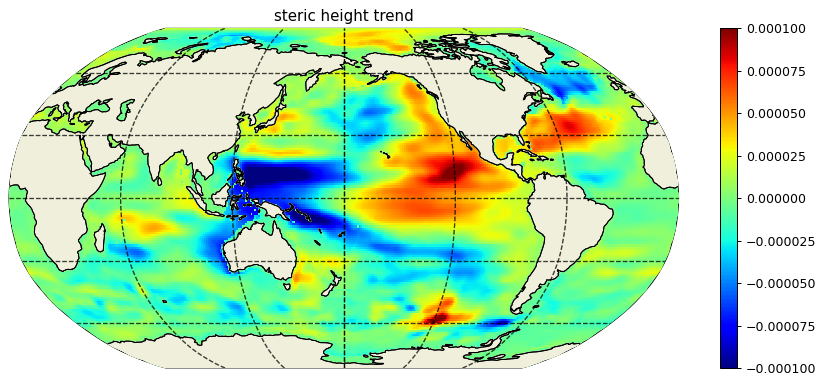

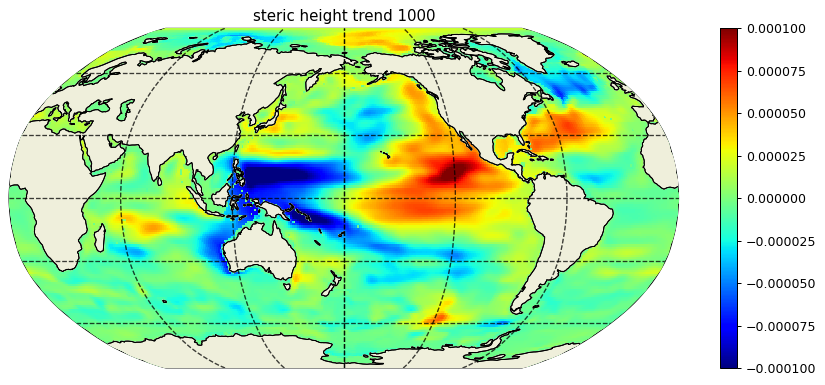

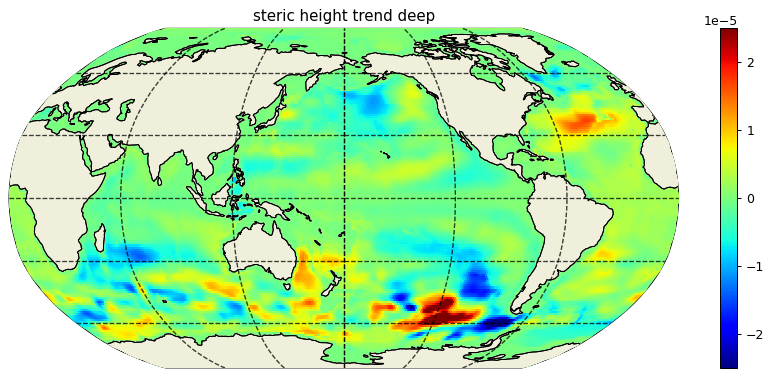

In [40]:
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, sh_trend, \
                              user_lon_0=180,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet',cmin=-0.0001,cmax=0.0001);
plt.title('steric height trend');
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, sh_1000_trend, \
                              user_lon_0=180,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet',cmin=-0.0001,cmax=0.0001);
plt.title('steric height trend 1000');
plt.figure(figsize=(12,5), dpi= 90)
ecco.plot_proj_to_latlon_grid(ecco_monthly_ds.XC, ecco_monthly_ds.YC, sh_deep_trend, \
                              user_lon_0=180,plot_type='pcolormesh',show_colorbar=True,dx=1,dy=1,cmap='jet',cmin=-0.000025,cmax=0.000025);
plt.title('steric height trend deep');

In [81]:
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask[0,:])
steric_height_anom = steric_height_jmd_xr # - steric_height_jmd_xr.mean(dim=['tile','j','i'])
SH_global_mean_mon = (steric_height_anom*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SH_global_mean_mon = SH_global_mean_mon # - SH_global_mean_mon.mean(dim='time')

In [82]:
SSHDYN_global_mean_mon = (ecco_monthly_ds.SSHDYN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
SSHDYN_global_mean_mon = SSHDYN_global_mean_mon - SSHDYN_global_mean_mon.mean(dim=['time'])
OBP_global_mean_mon = ((ecco_monthly_ds.OBPNOPAB)*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area
OBP_global_mean_mon = OBP_global_mean_mon - OBP_global_mean_mon.mean(dim=['time'])

# obp = ecco_monthly_ds.OBPNOPAB - ecco_monthly_ds.OBPNOPAB.mean(dim=['i','j','tile'])
# obp_global_mean = (obp*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area

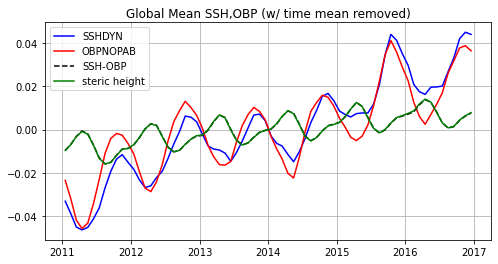

In [83]:
# SSHDYN_global_mean_mon.plot(color='r');
# OBP_global_mean_mon.plot(color='b');
f, (ax1) = plt.subplots(1,1,figsize=(8,4))
steric_height_check =  SSHDYN_global_mean_mon - OBP_global_mean_mon
ax1.plot(steric_height_check.time, SSHDYN_global_mean_mon, color='b', label='SSHDYN');
ax1.plot(steric_height_check.time, OBP_global_mean_mon, color='r', label='OBPNOPAB');
ax1.plot(steric_height_check.time, 1*steric_height_check, color='k', label='SSH-OBP', linestyle='--');
ax1.plot(steric_height_check.time, SH_global_mean_mon - SH_global_mean_mon.mean(dim='time'), color='g', label='steric height');
ax1.set_title('Global Mean SSH,OBP (w/ time mean removed)'); ax1.legend(); ax1.grid()

In [44]:
metrics = {
    ('X',): ['dxC', 'dxG'], # X distances
    ('Y',): ['dyC', 'dyG'], # Y distances
    ('X', 'Y'): ['rA', 'rAz', 'rAs', 'rAw'] # Areas
}
grid = Grid(ecco_monthly_ds, metrics=metrics)

In [45]:
# H_l = grid.interp(ecco_monthly_ds.Depth,'X')
# test = (grid.diff(H_l, 'X' ))/ecco_monthly_ds.dxC
testx = grid.derivative(ecco_monthly_ds.Depth,'X')
testy = grid.derivative(ecco_monthly_ds.Depth,'Y')

H_x = grid.interp(testx,'X')
H_y = grid.interp(testy,'Y')

In [47]:
grid

<xgcm.Grid>
T Axis (periodic, boundary=None):
  * center   time
Z Axis (periodic, boundary=None):
  * center   k --> left
  * outer    k_p1 --> center
  * right    k_u --> center
  * left     k_l --> center
X Axis (periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

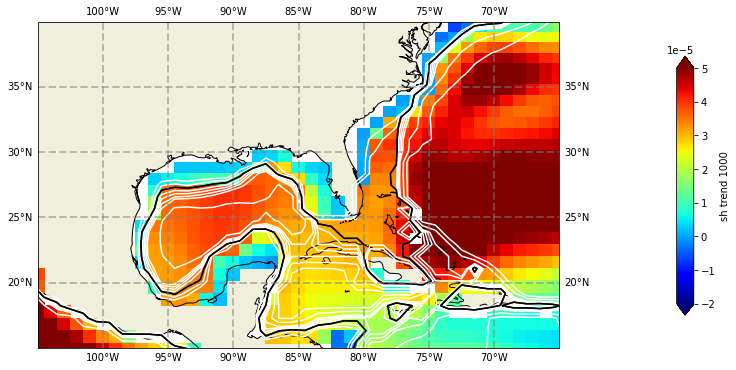

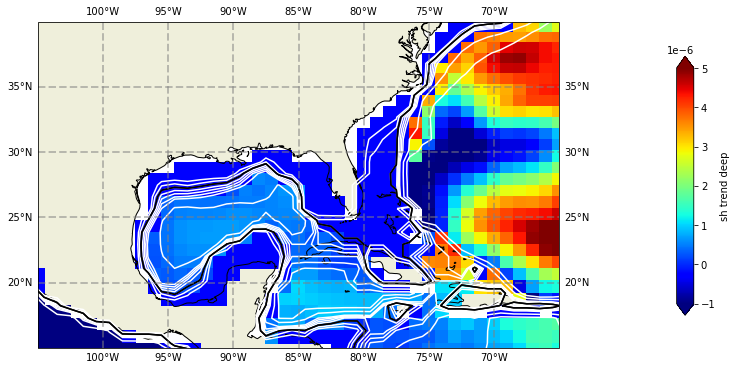

In [138]:
tile_num=10
# pull out lats and lons
lons = np.copy(ecco_monthly_ds.XC.sel(tile=tile_num))
lats = ecco_monthly_ds.YC.isel(tile=tile_num)
tile_to_plot = sh_1000_trend.isel(tile=tile_num) # steric height trend
Dep_tile_to_plot = ecco_monthly_ds.Depth.isel(tile=tile_num)
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
oo = ax.pcolor(lons, lats, tile_to_plot, vmin=-0.00002, vmax=0.00005, transform=ccrs.PlateCarree(), cmap='jet') # vmin=-0.0001, vmax=0.0001,
ax.contour(lons, lats, Dep_tile_to_plot, levels=[500, 750, 1000, 1250, 1500, 1750, 2000, 3000, 4000], colors='w')
ax.contour(lons, lats, Dep_tile_to_plot, levels=[1000, 1001], colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines();ax.add_feature(cfeature.LAND);
cax = f.add_axes([0.95, 0.2, 0.02, 0.6])
ax.set_xlim([-105, -65]); ax.set_ylim([15, 40]);
f.colorbar(oo, cax=cax, orientation='vertical', extend='both', label='sh trend 1000')

tile_to_plot = sh_deep_trend.isel(tile=tile_num) # steric height trend
Dep_tile_to_plot = ecco_monthly_ds.Depth.isel(tile=tile_num)
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)
f, ax = plt.subplots(1,1,figsize=(12,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
oo = ax.pcolor(lons, lats, tile_to_plot, vmin=-0.000001, vmax=0.000005, transform=ccrs.PlateCarree(), cmap='jet') # vmin=-0.0001, vmax=0.0001,
ax.contour(lons, lats, Dep_tile_to_plot, levels=[500, 750, 1000, 1250, 1500, 1750, 2000, 3000, 4000], colors='w')
ax.contour(lons, lats, Dep_tile_to_plot, levels=[1000, 1001], colors='k')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines();ax.add_feature(cfeature.LAND);
cax = f.add_axes([0.95, 0.2, 0.02, 0.6])
ax.set_xlim([-105, -65]); ax.set_ylim([15, 40]);
f.colorbar(oo, cax=cax, orientation='vertical', extend='both', label='sh trend deep')

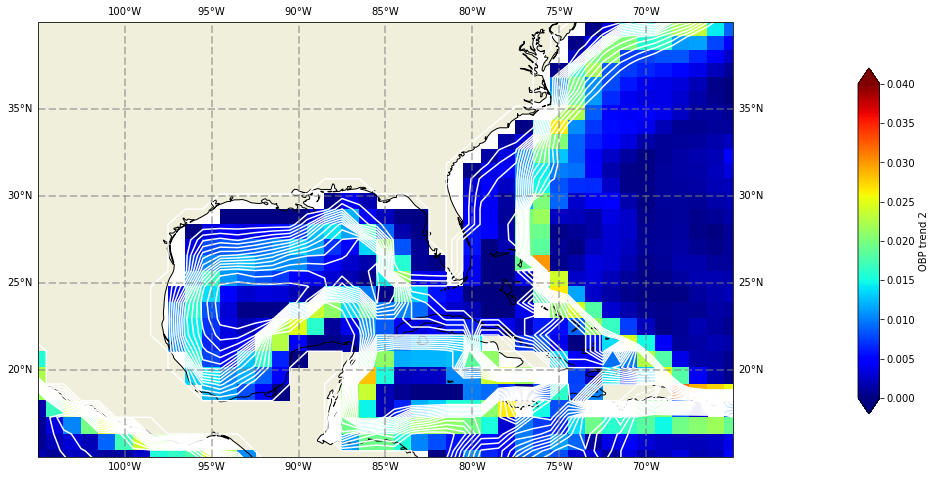

In [140]:
tile_num=10
# pull out lats and lons
lons = np.copy(ecco_monthly_ds.XC.sel(tile=tile_num))
lats = ecco_monthly_ds.YC.isel(tile=tile_num)

gradH_np = np.sqrt(H_x.isel(tile=tile_num).data**2 + H_y.isel(tile=tile_num).data**2)
gradH = xr.DataArray(
    data=gradH_np,
    dims=["j", "i"],
    coords=dict(
        i=(["i"], np.arange(90)), j=(["j"], np.arange(90)),
    ),
)

# tile_to_plot = sh_1000_trend.isel(tile=tile_num) # steric height trend
tile_to_plot = gradH
Dep_tile_to_plot = ecco_monthly_ds.Depth.isel(tile=tile_num)
tile_to_plot= tile_to_plot.where(ecco_monthly_ds.hFacC.isel(tile=tile_num,k=0) !=0, np.nan)

f, ax = plt.subplots(1,1,figsize=(15,8), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
oo = ax.pcolor(lons, lats, tile_to_plot, vmin=0, vmax=0.04, transform=ccrs.PlateCarree(), cmap='jet') # vmin=-0.0001, vmax=0.0001,
# ax.quiver(lons,lats,H_x.isel(tile=tile_num),H_y.isel(tile=tile_num),transform=ccrs.PlateCarree())
ax.contour(lons, lats, Dep_tile_to_plot, levels=np.arange(0,4000,250), colors='w')
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--');
ax.coastlines();ax.add_feature(cfeature.LAND);
cax = f.add_axes([0.95, 0.2, 0.02, 0.6])
ax.set_xlim([-105, -65]); ax.set_ylim([15, 40]);
f.colorbar(oo, cax=cax, orientation='vertical', extend='both', label='OBP trend 2')